# MAGeCK demo

## Generate synthetic data

,gene_effect_size
A,1.827486
B,0.826860
C,1.125181
D,1.610575
E,0.913777
F,1.319756
G,1.752255
H,1.909137
I,0.464732
J,1.867858


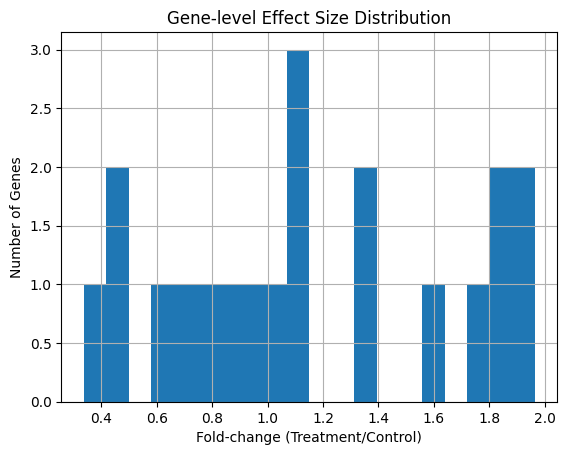

,C1,C2,C3,T1,T2,T3
A_1,988,1022,963,1862,1801,1834
A_2,1009,1035,967,1693,1745,1722
A_3,982,994,1010,1758,1749,1814
A_4,980,996,970,1727,1712,1675
B_1,1008,1010,982,882,769,830
...,...,...,...,...,...,...
S_4,995,1075,973,342,325,356
T_1,1011,955,1002,383,427,464
T_2,1002,1005,1042,440,439,438
T_3,960,1025,1019,445,397,424


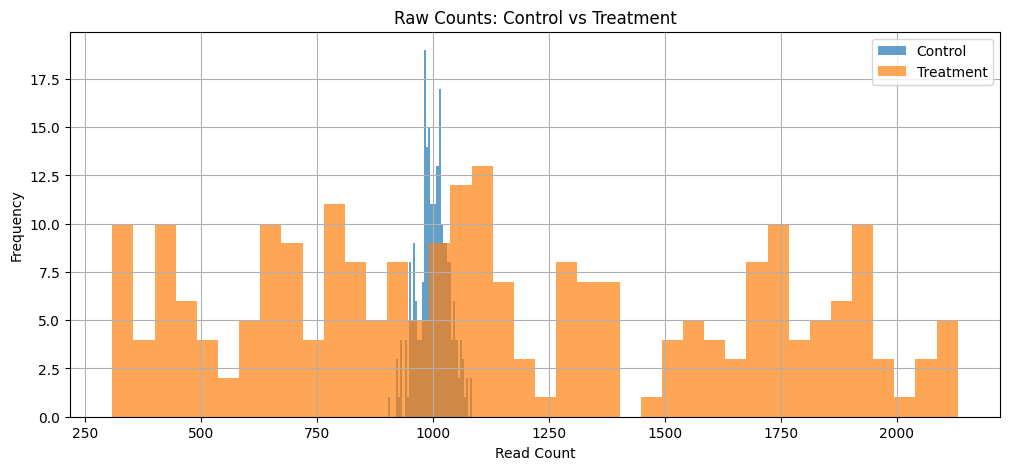

In [1]:
# --- Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.stats import nbinom

# --- Parameters ---
np.random.seed(42)
genes = [chr(65+i) for i in range(20)]  # Genes A to T
guides_per_gene = 4
rep_ctrl, rep_trt = 3, 3
variation_scale = 0.05   # smaller = more correlated guides
index = [f"{g}_{i}" for g in genes for i in range(1, guides_per_gene+1)]

# --- Step 0: Synthetic Dataset with Strongly Correlated Guides ---
# Control counts
ctl = np.random.poisson(1000, size=(len(index), rep_ctrl))

# Gene-level base effects (uniform 0.2–2.0)
effect_sizes = {g: np.random.uniform(0.2, 2.0) for g in genes}
# Build per-guide effects with low random variation
effect_vector = []
for g in genes:
    base = effect_sizes[g]
    # all guides vary by ~5%
    guide_variations = np.random.normal(loc=1.0, scale=variation_scale, size=guides_per_gene)
    effect_vector.extend(base * guide_variations)

eff_df = pd.DataFrame.from_dict(effect_sizes, orient='index', columns=['gene_effect_size'])
display(eff_df)
plt.figure()
eff_df['gene_effect_size'].hist(bins=20)
plt.title("Gene-level Effect Size Distribution")
plt.xlabel("Fold-change (Treatment/Control)")
plt.ylabel("Number of Genes")
plt.show()

# Treatment counts based on highly correlated guide effects
trt = np.zeros((len(index), rep_trt), dtype=int)
for idx, fc in enumerate(effect_vector):
    mu = 1000 * fc
    trt[idx] = np.random.poisson(mu, size=rep_trt)

# Combine into DataFrame
counts_df = pd.DataFrame(
    np.hstack([ctl, trt]), index=index,
    columns=[f"C{i}" for i in range(1, rep_ctrl+1)] + [f"T{i}" for i in range(1, rep_trt+1)]
)

display(counts_df)
plt.figure(figsize=(12,5))
counts_df.iloc[:, :rep_ctrl].stack().hist(bins=40, alpha=0.7)
counts_df.iloc[:, rep_ctrl:].stack().hist(bins=40, alpha=0.7)
plt.legend(['Control','Treatment'])
plt.title("Raw Counts: Control vs Treatment")
plt.xlabel("Read Count")
plt.ylabel("Frequency")
plt.show()

## Median-ratio normalization

,size_factor
C1,31.115008
C2,31.583969
C3,31.630157
T1,33.192684
T2,31.848250
T3,31.847991


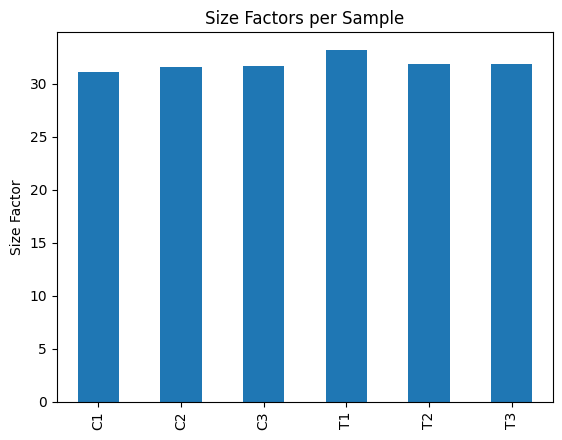

,C1,C2,C3,T1,T2,T3
A_1,32,32,30,56,57,58
A_2,32,33,31,51,55,54
A_3,32,31,32,53,55,57
A_4,31,32,31,52,54,53
B_1,32,32,31,27,24,26
...,...,...,...,...,...,...
S_4,32,34,31,10,10,11
T_1,32,30,32,12,13,15
T_2,32,32,33,13,14,14
T_3,31,32,32,13,12,13


<Figure size 640x480 with 0 Axes>

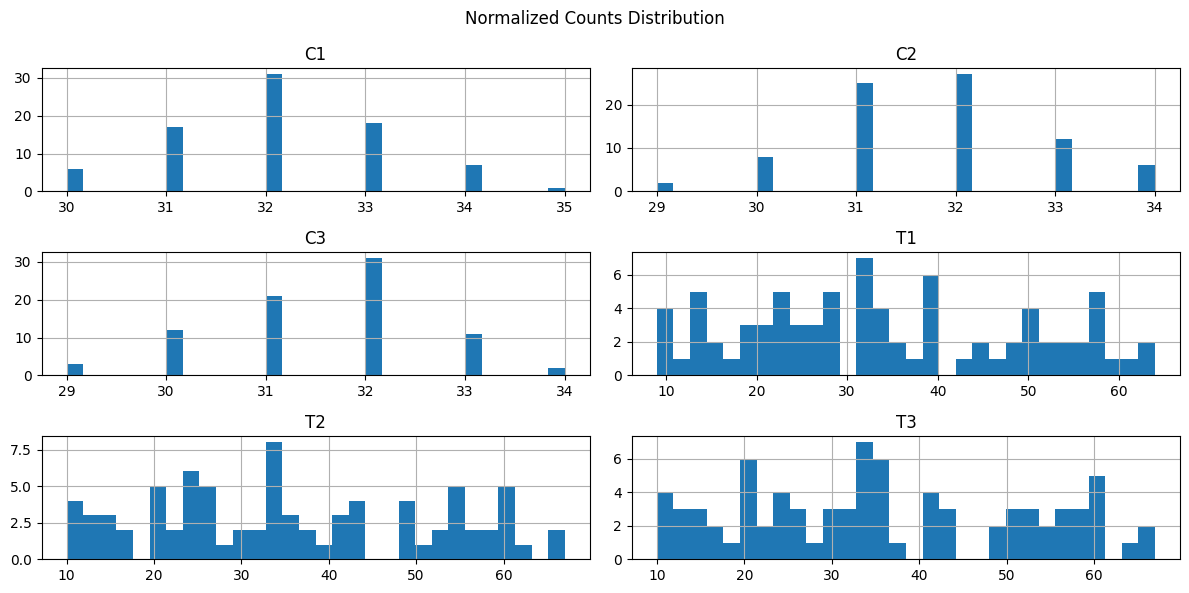

In [2]:
# --- Step 1: Median-Ratio Normalization ---
geomean = counts_df.prod(axis=1) ** (1 / counts_df.shape[1])
ratios = counts_df.div(geomean, axis=0)
size_factors = ratios.median(axis=0)
display(size_factors.to_frame(name='size_factor'))

plt.figure()
size_factors.plot.bar()
plt.title("Size Factors per Sample")
plt.ylabel("Size Factor")
plt.show()

norm_counts = counts_df.div(size_factors, axis=1).round().astype(int)
display(norm_counts)

plt.figure()
norm_counts.hist(figsize=(12, 6), bins=30)
plt.suptitle("Normalized Counts Distribution")
plt.tight_layout()
plt.show()

## Negative binomial

C:\Users\james\AppData\Local\Temp\ipykernel_34888\3991145158.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [nbinom.sf(trt_sum[i] - 1, size[i], prob[i]) for i in range(len(mu))],


,p_value
A_1,1.610207e-67
A_2,2.252816e-58
A_3,1.614490e-62
A_4,7.688333e-59
B_1,7.177909e-12
...,...
S_4,6.163165e-01
T_1,7.631856e-02
T_2,7.932807e-02
T_3,1.501354e-01


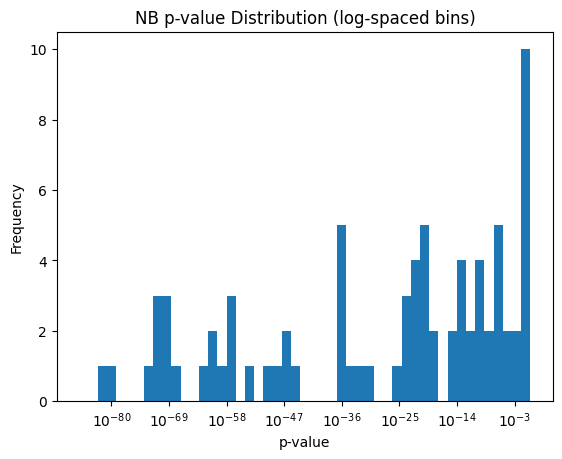

In [3]:
ctrl_df = norm_counts.iloc[:, :rep_ctrl]
trt_df  = norm_counts.iloc[:, rep_ctrl:]

mu = ctrl_df.mean(axis=1)
var = ctrl_df.var(axis=1, ddof=1)
dispersion = ((var - mu) / mu**2).clip(lower=1e-6)
size = 1 / dispersion
prob = size / (size + mu)

trt_sum = trt_df.sum(axis=1)
pvals = pd.Series(
    [nbinom.sf(trt_sum[i] - 1, size[i], prob[i]) for i in range(len(mu))],
    index=ctrl_df.index,
    name='p_value'
)
display(pvals.to_frame())

# find the min non-zero p-value
min_p = pvals[pvals>0].min()

# build, say, 50 log-spaced bins between min_p and 1
bins = np.logspace(np.log10(min_p), 0, 50)

plt.figure()
plt.hist(pvals, bins=bins)
plt.xscale('log')
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.title('NB p-value Distribution (log-spaced bins)')
plt.show()


## simplified RRA

In [5]:
# --- Step 4: True RRA with Binomial Null ---
from scipy.stats import binom

def rra_pvalue(ranks, total_guides):
    '''Compute RRA p-value for one gene given its guide ranks.'''
    m = len(ranks)
    ranks_sorted = np.sort(ranks)
    p_vals = []
    for i, r in enumerate(ranks_sorted, start=1):
        u = r / total_guides
        # P(X >= i) for X ~ Binomial(m, u)
        p = binom.sf(i-1, m, u)
        p_vals.append(p)
    return np.min(p_vals)

# Compute gene-level RRA p-values
total_guides = len(ranks)
gene_rra = {g: rra_pvalue([r for guide, r in ranks.items() if guide.startswith(g+'_')], total_guides) for g in genes}
rra_scores = pd.Series(gene_rra, name='RRA_p').sort_index()
display(rra_scores.to_frame())

plt.figure(figsize=(8,4))
plt.bar(rra_scores.index, rra_scores)
plt.title("Gene-level RRA p-values")
plt.ylabel("RRA p-value")
plt.yscale('log')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

NameError: name 'ranks' is not defined

## BH correction

In [ ]:
# --- Step 5: Benjamini-Hochberg FDR Correction ---
def bh_correction(pvals):
    m = len(pvals)
    sorted_p = pvals.sort_values()
    ranks = np.arange(1, m+1)
    bh = (sorted_p * m / ranks).clip(upper=1)
    # enforce monotonicity
    bh = bh[::-1].cummin()[::-1]
    return bh.sort_index().rename('q_value')

qvals = bh_correction(rra_scores)
display(qvals.to_frame())

plt.figure(figsize=(8,4))
plt.bar(qvals.index, qvals)
plt.title("Gene-level FDR q-values")
plt.ylabel("q-value")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
# --- Step 6: Summary Table of Ranked Hits ---
log2fc = (np.log2(trt_df.mean(axis=1)) - np.log2(ctrl_df.mean(axis=1))).rename("log2FC")
lfc_gene = log2fc.groupby(log2fc.index.str.extract(r'(^[A-Z])')[0]).mean()

summary = pd.concat([lfc_gene, rra_scores, qvals], axis=1)
summary.columns = ['log2FC', 'RRA_p', 'q_value']
sorted_summary = summary.sort_values('q_value')
display(sorted_summary)

plt.figure(figsize=(8, 6))
plt.scatter(summary['log2FC'], -np.log10(summary['q_value']), c='blue')
plt.axhline(-np.log10(0.05), color='red', linestyle='--')
plt.title("Volcano Plot of Gene Hits")
plt.xlabel("log2 Fold Change")
plt.ylabel("-log10(q-value)")
plt.grid(True)
plt.tight_layout()
plt.show()